### News


Introducing FP8 precision training for faster RL inference. [Read Blog](https://docs.unsloth.ai/new/fp8-reinforcement-learning).

Unsloth's [Docker image](https://hub.docker.com/r/unsloth/unsloth) is here! Start training with no setup & environment issues. [Read our Guide](https://docs.unsloth.ai/new/how-to-train-llms-with-unsloth-and-docker).

[gpt-oss RL](https://docs.unsloth.ai/new/gpt-oss-reinforcement-learning) is now supported with the fastest inference & lowest VRAM. Try our [new notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/gpt-oss-(20B)-GRPO.ipynb) which creates kernels!

Introducing [Vision](https://docs.unsloth.ai/new/vision-reinforcement-learning-vlm-rl) and [Standby](https://docs.unsloth.ai/basics/memory-efficient-rl) for RL! Train Qwen, Gemma etc. VLMs with GSPO - even faster with less VRAM.

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

In [ ]:
# Unsloth

Let's prepare the OCR model to our local first

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

KeyboardInterrupt: 

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Qwen3-VL-8B-Instruct-bnb-4bit", # Qwen 3 vision support
    "unsloth/Qwen3-VL-8B-Thinking-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Instruct-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Thinking-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    auto_model = AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

In [ ]:
!wget -O dataset.zip "https://huggingface.co/datasets/lehoangan02/nlp/resolve/main/dataset.zip?download=true"
!unzip -q dataset.zip

In [ ]:
from datasets import load_dataset

# Load raw JSON. Do NOT process images here.
dataset_train = load_dataset("json", data_files="dataset/deepseek_train.json")["train"]
dataset_val   = load_dataset("json", data_files="dataset/deepseek_val.json")["train"]

# Assign to the variables expected by the Trainer
a = dataset_train
converted_val = dataset_val
converted_train = dataset_train

print(f"Train samples: {len(converted_train)}")
print(f"Val samples: {len(converted_val)}")

In [ ]:
sample = dataset_val[0]
sample['messages'][0]['images'][0]  # for image
sample['messages'][1]['content']   # for OCR text


In [ ]:
# Save an image that will not be used during training for evaluation purposes
from PIL import Image

# Example: pick first sample in validation set
sample = dataset_val[0]
image_path = sample['messages'][0]['images'][0]  # path from your JSON
Image.open(image_path).save("your_image.jpg")

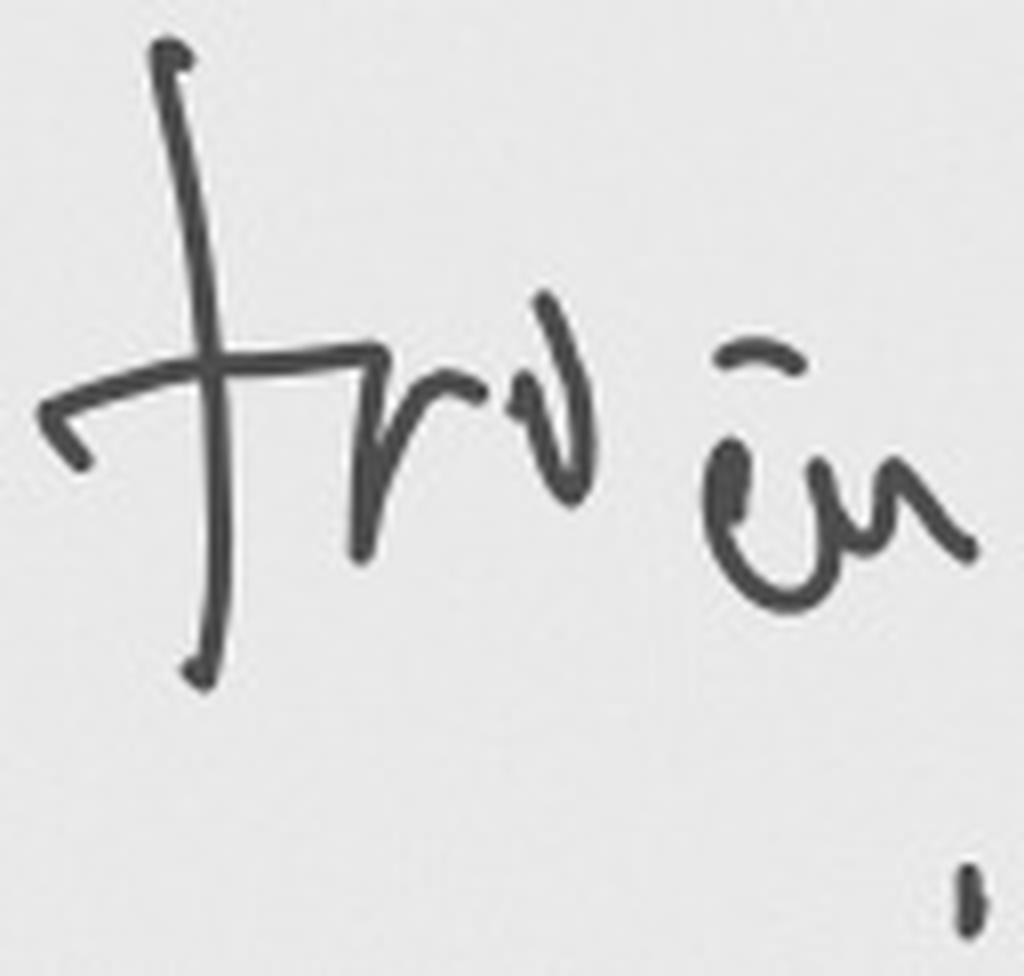

In [ ]:
from IPython.display import Image, display

display(Image(filename='your_image.jpg'))

<h3>Baseline Model Performance: 23% Character Error Rate (CER) for this sample !</h3>

# Let's finetune Deepseek-OCR !

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model` require gradients


# Data prep

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "<|User|>",
  "content": "",
  "images": []
},
{ "role": "<|Assistant|>",
  "content": ""
},
]
```

In [ ]:
instruction = "<image>\nFree OCR. "

def convert_to_conversation(sample):
    """Convert dataset sample to conversation format"""
    conversation = [
        {
            "role": "<|User|>",
            "content": instruction,
            "images": [sample['image']]
        },
        {
            "role": "<|Assistant|>",
            "content": sample["text"]
        },
    ]
    return {"messages": conversation}


Let's convert the dataset into the "correct" format for finetuning:

We look at how the conversations are structured for the first example:

In [ ]:
# @title Create datacollator

import torch
import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    format_messages,
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(
        self,
        tokenizer,
        model,
        image_size: int = 640,
        base_size: int = 1024,
        crop_mode: bool = True,
        train_on_responses_only: bool = True,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean=(0.5, 0.5, 0.5),
            std=(0.5, 0.5, 0.5),
            normalize=True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
            self.bos_id = tokenizer.bos_token_id
        else:
            self.bos_id = 0

    def deserialize_image(self, image_data) -> Image.Image:
        # THIS IS THE FIX: Handle file paths (strings) directly
        if isinstance(image_data, str):
            try:
                return Image.open(image_data).convert("RGB")
            except Exception as e:
                # Create a black placeholder image if loading fails to prevent crash
                print(f"Error loading image {image_data}: {e}")
                return Image.new('RGB', (100, 100), color='black')
        elif isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            image_bytes = image_data['bytes']
            image = Image.open(io.BytesIO(image_bytes))
            return image.convert("RGB")
        else:
            raise ValueError(f"Unsupported image format: {type(image_data)}")

    def calculate_image_token_count(self, image: Image.Image, crop_ratio: Tuple[int, int]) -> int:
        num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
        num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
        width_crop_num, height_crop_num = crop_ratio

        if self.crop_mode:
            img_tokens = num_queries_base * num_queries_base + 1
            if width_crop_num > 1 or height_crop_num > 1:
                img_tokens += (num_queries * width_crop_num + 1) * (num_queries * height_crop_num)
        else:
            img_tokens = num_queries * num_queries + 1
        return img_tokens

    def process_image(self, image: Image.Image) -> Tuple[List, List, List, List, Tuple[int, int]]:
        images_list = []
        images_crop_list = []
        images_spatial_crop = []

        if self.crop_mode:
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num=2, max_num=9,
                    image_size=self.image_size, use_thumbnail=False
                )

            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color=tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(self.image_transform(crop_img).to(self.dtype))

            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num)

        else:
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color=tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
            images = []
            for message in messages:
                if "images" in message and message["images"]:
                    for img_data in message["images"]:
                        if img_data is not None:
                            pil_image = self.deserialize_image(img_data)
                            images.append(pil_image)

            if not images:
                # Fallback for text-only or missing image
                images.append(Image.new('RGB', (100, 100), color='black'))

            tokenized_str = []
            images_seq_mask = []
            images_list, images_crop_list, images_spatial_crop = [], [], []
            prompt_token_count = -1
            assistant_started = False
            image_idx = 0

            tokenized_str.append(self.bos_id)
            images_seq_mask.append(False)

            for message in messages:
                role = message["role"]
                content = message["content"]

                if role == "<|Assistant|>":
                    if not assistant_started:
                        prompt_token_count = len(tokenized_str)
                        assistant_started = True
                    content = f"{content.strip()} {self.tokenizer.eos_token}"

                text_splits = content.split('<image>')
                for i, text_sep in enumerate(text_splits):
                    tokenized_sep = text_encode(self.tokenizer, text_sep, bos=False, eos=False)
                    tokenized_str.extend(tokenized_sep)
                    images_seq_mask.extend([False] * len(tokenized_sep))

                    if i < len(text_splits) - 1:
                        if image_idx < len(images):
                            image = images[image_idx]
                            img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(image)
                            images_list.extend(img_list)
                            images_crop_list.extend(crop_list)
                            images_spatial_crop.extend(spatial_crop)
                            tokenized_str.extend(tok_img)
                            images_seq_mask.extend([True] * len(tok_img))
                            image_idx += 1

            images_ori = torch.stack(images_list, dim=0)
            images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype=torch.long)
            if images_crop_list:
                images_crop = torch.stack(images_crop_list, dim=0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype=self.dtype)

            return {
                "input_ids": torch.tensor(tokenized_str, dtype=torch.long),
                "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
                "images_ori": images_ori,
                "images_crop": images_crop,
                "images_spatial_crop": images_spatial_crop_tensor,
                "prompt_token_count": prompt_token_count,
            }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch_data = []
        for feature in features:
            try:
                processed = self.process_single_sample(feature['messages'])
                batch_data.append(processed)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if not batch_data:
            # Emergency fallback to prevent crash if entire batch fails
            raise ValueError("No valid samples in batch")

        input_ids = pad_sequence([x['input_ids'] for x in batch_data], batch_first=True, padding_value=self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence([x['images_seq_mask'] for x in batch_data], batch_first=True, padding_value=False)
        labels = input_ids.clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        labels[images_seq_mask] = -100

        if self.train_on_responses_only:
            for idx, item in enumerate(batch_data):
                if item['prompt_token_count'] > 0:
                    labels[idx, :item['prompt_token_count']] = -100

        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()
        images_batch = [(x['images_crop'], x['images_ori']) for x in batch_data]
        images_spatial_crop = torch.cat([x['images_spatial_crop'] for x in batch_data], dim=0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `DeepSeekOCRDataCollator` which will help in our vision finetuning setup.

In [ ]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported
FastVisionModel.for_training(model) # Enable for training!
data_collator = DeepSeekOCRDataCollator(
    tokenizer=tokenizer,
    model = model,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    train_on_responses_only=True,
)
trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = data_collator, # Must use!
    train_dataset = converted_train,
    eval_dataset  = converted_val,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        fp16 = not is_bf16_supported(),  # Use fp16 if bf16 is not supported
        bf16 = is_bf16_supported(),  # Use bf16 if supported
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases
        dataloader_num_workers=2,
        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
    ),
)

/tmp/ipython-input-701024634.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.855 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 96,846 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
Unsloth: Will smartly offload gradients to save VRAM!
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])


Step,Training Loss
1,6.452400
2,6.863700
3,5.635200
4,4.650300
5,4.424200
6,3.291400
7,2.823400
8,2.195100
9,1.612300
10,0.876300


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([2, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([2, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([4, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

884.8921 seconds used for training.
14.75 minutes used for training.
Peak reserved memory = 10.57 GB.
Peak reserved memory for training = 3.715 GB.
Peak reserved memory % of max memory = 71.705 %.
Peak reserved memory for training % of max memory = 25.202 %.


<a name="Inference"></a>
### Inference
Let's run the model!

In [ ]:
prompt = "<image>\nFree OCR. "
image_file = 'your_image.jpg'
output_path = './output'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file,
    output_path = output_path,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    save_results = True,
    test_compress = False)


['', '\nFree OCR.']
انضباطم نشدم حقیقتن باورم نمیشد
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


With only 60 steps, we dramatically improved the transcription quality. The Character Error Rate (CER) on this single sample dropped from 23% to 6%, a 74% relative reduction!

| Type | OCR |
| :--- | :--- |
| **Baseline (Pre-Finetune)** | `انضباطم نندم حقيقتن باورم نميتند` |
| **Finetuned (60 steps)** | `انضباطم نشدم حقیقتن باورم نمیشد` |
| **Ground Truth** | `انضباطمم شدم حقیقتن باورم نمیشد` |

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
import shutil
from google.colab import files

# Zip the folder
shutil.make_archive('lora_model', 'zip', 'lora_model')

# Download the zip file
files.download('lora_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
        auto_model = AutoModel,
        trust_remote_code=True,
        unsloth_force_compile=True,
        use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    )
    FastVisionModel.for_inference(model) # Enable for inference!

prompt = "<image>\nFree OCR. "
image_file = 'your_image.jpg'
output_path = './output'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt=prompt, image_file=image_file,
    output_path = output_path,
    image_size=640,
    base_size=1024,
    crop_mode=True,
    save_results = True,
    test_compress = False)


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")